<font color='red' size='6'> Warning! rerun all the codes might lead to different results as I have seen the results differe when I run the codes in one day and another while no code was modified. Please review the script first before try it yourself</font>

# Load Data

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [181]:
df = pd.read_csv('speed_dating.csv')
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[0-4],1.0,1
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1
4,0,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,4.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1


# Feature Engineering
By explor the dataset, I found there are 120 features (one is label) of which 59 features are categorical. With insight into the categorical features, it is found that there is only one feature, 'field', whoes distinct values varies largely. The reset categorical features only have roughly 3-5 different values. Thereby, I will use frequentcy/counts encoder to encode the 'field' feature and one hot encoder to encode the rest categorical features. Worth note: this may lead to a sparse dataset.

By looking closely to the 'field' feature, I also find that there are some values are only different due to letter case, i.e some values have its first letter in capital and some have it in lower case. In addition to that, they are the same. Thus it is better to lower the case of all the values in the 'field' feature before encoding.

At last, some features are highly correlated with other feature(s) such as those denote the differences between two other features, It may be helpful to drop these 'differences' features of other feature(s), for example 'd_d_age', 'd_importance_same_race', *etc* to avoid a sparse encoded dataset.

In [182]:
df['field'] = df['field'].str.lower()
X = df.copy()
y = pd.DataFrame(df.pop('match'), columns =['match'])

# Drop the 'difference' features, if you'd like to see the difference, you can comment the following line of code.
X = X.loc[:, ~X.columns.str.contains('d_')]

# Remove the label column from the features (In fact, it didn't make difference in the clustering results like droping the 'difference' features or not)
X.drop('match', axis=1, inplace=True)
# X.drop('has_null', axis=1, inplace=True)
Xtrain = X.copy()
ytrain = y.copy()
Xtrain.head()

,has_null,wave,gender,age,age_o,race,race_o,samerace,importance_same_race,importance_same_religion,...,theater,movies,concerts,music,shopping,yoga,interests_correlate,like,guess_prob_liked,met
0,0,1.0,female,21.0,27.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.14,7.0,6.0,0.0
1,0,1.0,female,21.0,22.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.54,7.0,5.0,1.0
2,1,1.0,female,21.0,22.0,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.16,7.0,5.0,1.0
3,0,1.0,female,21.0,23.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.61,7.0,6.0,0.0
4,0,1.0,female,21.0,24.0,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.21,6.0,6.0,0.0


<font color='skyblue'>If you liked to have train and test datasets, you can uncommen and run the following line of code (again, it won't make significant difference)</font>


In [183]:
from sklearn.model_selection import train_test_split

# Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)

## Preprocessing data

<font color='skyblue' size='5'>speparate the numerical, categorical, and the 'field' features.</font>

In [184]:
cat_col = Xtrain.select_dtypes(include='object').columns.drop('field')
num_col = Xtrain.drop(columns=cat_col).columns.drop('field')
field_col = Xtrain.drop(columns=num_col).columns.drop(cat_col)

<font color='skyblue' size='5'>Create a pipeline</font>

In [185]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.count import CountEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

count_transformer = Pipeline(steps=[
    ('count', CountEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('numeric', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col),
        ('count', count_transformer, field_col)
    ]
)

preprocessor.fit(Xtrain)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'att...
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['gender', 'race', 'race_o'], dtype='object')),
                                ('count',
                                 Pipeline(steps=[('count',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown='ignore'))]),
                                 Index(['field'], dtype='object'))])

In [186]:
# get the encoded dataset, if you prefer to have test dataset, you need to uncomment the code in the next line
Xtrain_encoded = preprocessor.transform(Xtrain)
# Xtest_encoded = preprocessor.transform(Xtest)

In [187]:
# This part is to build the pandas dataframe for further usage in the cluster result analysis, it is not necessary for clustering

# get the numerical feature names
num_names_in = []
for i in range(num_col.shape[0]):
    num_names_in.append(num_col[i])
numeric_transformer = preprocessor.named_transformers_['num']
std_scaler = numeric_transformer.named_steps['numeric']
numeric_names = std_scaler.get_feature_names_out(num_col)

# get the categorical feature names
categorical_transformer = preprocessor.named_transformers_['cat']
cat_scaler = categorical_transformer.named_steps['onehot']
cat_names = cat_scaler.get_feature_names_out(cat_col)

# get the field names
field_transformer = preprocessor.named_transformers_['count']
field_scaler = field_transformer.named_steps['count']
field_names = field_scaler.feature_names_out_

encoded_num_cols = num_col
encoded_cat_cols = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_col)
encoded_count_cols = field_col

encoded_feature_names = np.concatenate((encoded_num_cols, encoded_cat_cols, encoded_count_cols))


# convert the encoded data to a DataFrame with the corresponding column names
Xtrain_encoded_df = pd.DataFrame(Xtrain_encoded, columns=encoded_feature_names)

### Feature selection

<font color='skyblue'>This part is for project features into a 2D space for visualization when we have the clusers from model selected.</font>

In [188]:
from sklearn.manifold import TSNE

tsne_reducer = TSNE(n_components=2, perplexity=120, method='barnes_hut', random_state=42)
tsne_embeding_train = tsne_reducer.fit_transform(Xtrain_encoded)
# tsne_embeding_test = tsne_reducer.fit_transform(Xtest_encoded)

# Modeling
## Build the models

<font color='skyblue'>I will show my original code to build models but only the Birch model is used in this final version of notebook

Agglomerative and BisectingKmeans models are removed due to poor performance.</font>

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS, Birch
import numpy as np

# all the parameters are set to its default values.
def build_model(n_clusters=2, 
                # n_estimators=100,   # parameters for random forest classifier
                init='random', n_init='auto', max_iter=300, tol=1e-4, random_state=None, algorithm_k='lloyd', verbose=0,    # parameters for kmeans model
                cluster_method='xi', min_cluster_size=None,   # parameters for optics model
                threshold=0.5, branching_factor=50,   # parameters for birch model
                algorithm='auto', eps=15, min_samples=5, metric='euclidean', metric_params = None, leaf_size=30, p=2, n_jobs=1    # parameters for dbscan model
                ):
    # this is not used in this final version of notebook
    randomforest = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, n_jobs=-1))])

    kmeans = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KMeans(n_clusters=n_clusters,
                        init=init,
                        n_init=n_init, 
                        max_iter=max_iter, 
                        tol=tol,
                        verbose=verbose,
                        random_state=random_state, 
                        algorithm=algorithm_k))])

    optics = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', OPTICS(min_samples=min_samples,
                        max_eps=np.inf, 
                        metric=metric, 
                        p=p, 
                        cluster_method=cluster_method, 
                        min_cluster_size=min_cluster_size, 
                        algorithm=algorithm, 
                        leaf_size=leaf_size))])

    birch = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Birch(threshold=threshold,
                        n_clusters=n_clusters, 
                        branching_factor=branching_factor,
                        ))])

    dbscan = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DBSCAN(eps=eps, 
                        min_samples=min_samples, 
                        metric=metric, 
                        metric_params=metric_params, 
                        leaf_size=leaf_size, 
                        p=p,
                        n_jobs=n_jobs))])
    return randomforest, kmeans, optics, birch, dbscan


### Train the model

<font color='skyblue' size='4'>By experimenting on different models, I found that KMEANS model does a fairly good job, but DBSCAN and Birch models are better while the OPTICS model is very poor in clustering performance. I will demenstrate the Birch model in this notebook and do further exploration on the clustered data. The KMEANS and DBSCAN models are also shown in the end of the notebook.</font>

For Birch model, the most significant parameters are 'n_clusters' (of course) and 'threshold'. Here I will just use the parameters that have been fine tuned.

I tried with the parameters settings that are optimised by silhouetter score and calinski-barahasz score. However, the obtained clusters are not good enought. There are some 'features' under the table that are always not learned by the cluster model. And same cluster labels can be seen in different groups of instances when visualizing the clusters. Yeah, the threshold value here is sort of wired, but it minimize the overlap between cluster instances. The branch factor is a defaut value.

I tried to use the parameters settings that are optimized by silhouette score and calinski-barahasz score but the resulting clusters are not good enough. There are some 'features' under the table that are always not learned by the cluster model with the 'optimized' parameter settings. And same cluster labels can be seen in different groups of instances sometimes when visualizing the clusters. Thereby, I decided to use the parameters I tuned by myself. The value of 'threshold' is 'wired' but it minimize the overlap of clusters that one cluster is seen in another cluster's instances group. 'branching_factor' is default value.

In [173]:
birch_model = build_model(n_clusters=16, threshold=8.53, branching_factor=50)[-2]
birch_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model', Birch(n_clusters=16, threshold=8.53))])

Retrieve the cluster labels and calculate the corresponding silhouette score. The resulting silhouette score implys that the cluster model has done a fair good job.

In [12]:
from sklearn.metrics import silhouette_score

bc_labels_train = birch_model.fit_predict(Xtrain)

bc_silhouette_score_train = silhouette_score(Xtrain_encoded, bc_labels_train)
print(bc_silhouette_score_train)

0.5461761839092141


# Visualization of the cluster

Here the plotted graph rotated and mirrored over night when I run the code again in the following day I coded it while I did not change any code. I think this is could be the seeds for randomization is different with the time. And I see different patterns with same code on my windows desktop compared to it on my mackbook laptop. That's why I have a warning at the top of the notebook.

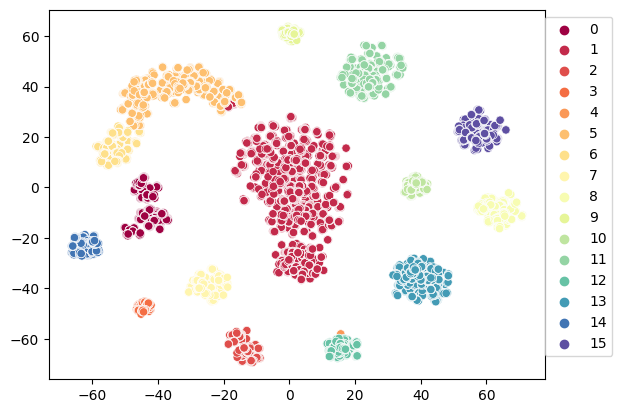

In [13]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=bc_labels_train, palette='Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

<font color='skyblue'> Let's put the label markers on the cluster at the centroid position. And color the instances with labels of matched or not matched

note: the labels order may be different when you run the code each time. So in the following discussion, the cluster label I mentioned are correct for this result showing bellow.
</font>

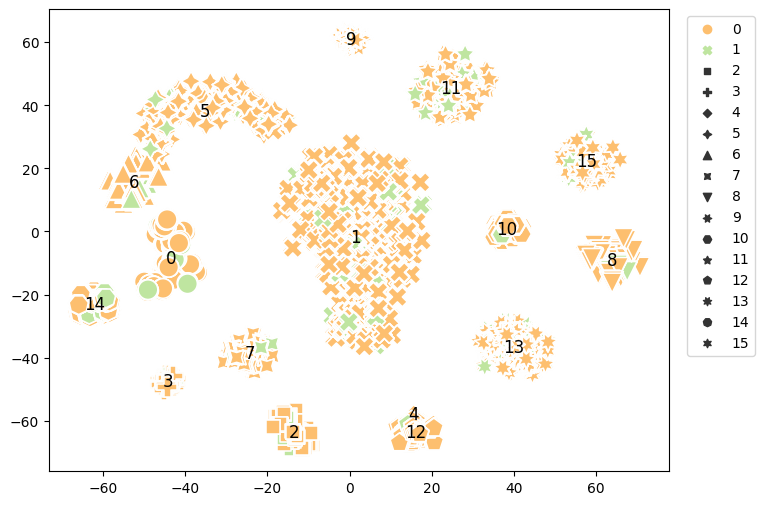

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=tsne_embeding_train[:,0], 
                     y=tsne_embeding_train[:,1], 
                     hue=ytrain.values.reshape(-1,), 
                     palette= 'Spectral', 
                     style=bc_labels_train,
                     s=200,
                     legend='full')

centroids = []
for i in np.unique(bc_labels_train):
    centroid = np.mean(tsne_embeding_train[bc_labels_train == i], axis=0)
    centroids.append(centroid)
    ax.text(centroid[0], centroid[1], str(i), fontsize=12, color='black', ha='center', va='center')

ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()


It is obvious that in each cluster, there are matched and unmatched dating. But wait, the cluster 4 seems wrongly clustered. Let's find out.

In [17]:
# Find the number of instances in each cluster
cluster_counts = np.bincount(bc_labels_train)

# Print the number of instances in each cluster
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} instances")


Cluster 0: 514 instances
Cluster 1: 2460 instances
Cluster 2: 325 instances
Cluster 3: 140 instances
Cluster 4: 2 instances
Cluster 5: 1033 instances
Cluster 6: 387 instances
Cluster 7: 372 instances
Cluster 8: 414 instances
Cluster 9: 177 instances
Cluster 10: 223 instances
Cluster 11: 694 instances
Cluster 12: 285 instances
Cluster 13: 604 instances
Cluster 14: 280 instances
Cluster 15: 468 instances


It is clear that cluster 4 is wrongly grouped as one cluster. It could be some noise in the two instances learned by the algorithm. Now let's temporarily ignore the 4th cluster for the following analysis.

# The ugly truth and beautiful side of speed dating

I will draw conclusions on the clustering during visualizing the data in the following steps. So, there is no final conclusion in a summary.

More conclusions can be obtained from further exploration. 

First let's see how the matched and unmatched instances are distributed in each cluster.

In [43]:
n_clusters = len(np.unique(bc_labels_train))

matched_density = np.zeros(n_clusters)

for i in range(n_clusters):
    cluster_indices = np.where(bc_labels_train == i)[0]
    n_matched = np.sum(ytrain.values[cluster_indices])
    matched_density[i] = n_matched / len(cluster_indices)

not_matched_density = np.ones(n_clusters)-matched_density

print('The match rate in each cluster is:', '\n', matched_density, '\n', '\n', 'The unmatch rate in each cluster, correspondingly, is: ' '\n', not_matched_density)

The match rate in each cluster is: 
 [0.17315175 0.15934959 0.16923077 0.17857143 0.5        0.15972894
 0.17054264 0.15591398 0.11594203 0.18644068 0.13901345 0.20317003
 0.12280702 0.21357616 0.15357143 0.1474359 ] 
 
 The unmatch rate in each cluster, correspondingly, is: 
 [0.82684825 0.84065041 0.83076923 0.82142857 0.5        0.84027106
 0.82945736 0.84408602 0.88405797 0.81355932 0.86098655 0.79682997
 0.87719298 0.78642384 0.84642857 0.8525641 ]


(0.5 is from 4th cluster, omit it) It seems that the matching rate is highly centered, so doest the unmatching rate.

In [20]:
avg_match = (np.sum(matched_density) - 0.5) / 15
avg_unmatch = (np.sum(not_matched_density) - 0.5) / 15
std_match = np.std(np.delete(matched_density, 4))
std_unmatch = np.std(np.delete(not_matched_density, 4))

print(f'The average matching rate is {avg_match}, and the unmatching rate is {avg_unmatch}')
print(f'The standard deviation of the matching rate is {std_match}, and the standard deviation of the unmatching rate is {std_unmatch}')


The average matching rate is 0.16322971949478518, and the unmatching rate is 0.8367702805052147
The standard deviation of the matching rate is 0.025783913969396163, and the standard deviation of the unmatching rate is 0.025783913969396176


Let's plot the matching rate vs the cluster labels

In [25]:
# Let's first remove the 'anomaly' cluster, the 4th cluster.
rounded_match = np.around(matched_density, 2)
rounded_unmatch = np.around(not_matched_density, 2)
mask = rounded_match == 0.5
rounded_match = rounded_match[~mask]
rounded_unmatch = rounded_unmatch[~mask]

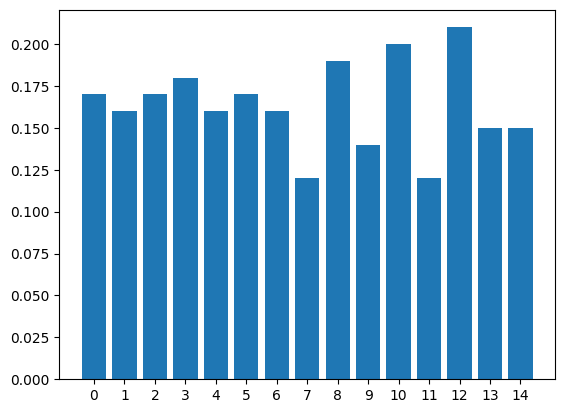

In [26]:
plt.bar(range(len(rounded_match)), rounded_match)
plt.xticks(range(len(rounded_match)))
plt.show()

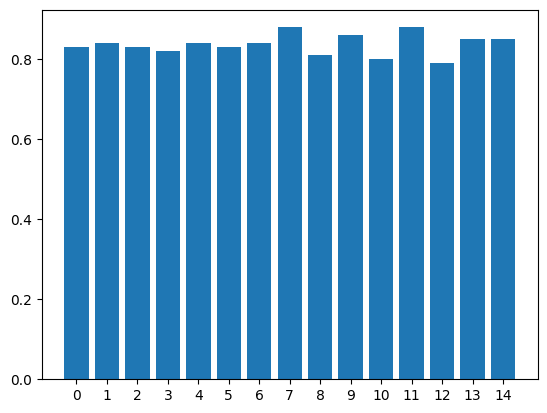

In [27]:
plt.bar(range(len(rounded_unmatch)), rounded_unmatch)
plt.xticks(range(len(rounded_unmatch)))
plt.show()

Obviously, some features in the cluster 9 (x=8 in the above figure), 11 (x=10), and 13 (x=12) are different that it is in other clusters so that they increase the match rate more than others.

So does some features in the cluster 8 (x=7), 10 (x=9), and 12 (x=11) that decrease the match rate more than others as seen in the second graph above.

(Although the above discussion is based on the not-significant differences between the clusters)

## Further study: let's try to find what's happening here.

I will calculate the feature importance to find the most important features for matching rate.

First, I concatenate the encoded dataframe with the cluster labels, Then splite the dataset into train and test sets. Next, I'll caculate the importance for all the cases, 'macthed' case and the 'matched' case in 13th cluster by random forest classifier.

In [28]:
# add the cluster labels to the encoded data frame
bc_labels_train_df = pd.DataFrame(bc_labels_train, columns = ['birch cluster labels'])
Xtrain_with_cluster_labels = pd.concat([Xtrain_encoded_df, bc_labels_train_df], axis=1)
Xtrain_with_cluster_labels.head()

,has_null,wave,age,age_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,...,race_European/Caucasian-American,race_Latino/Hispanic American,race_Other,race_o_Asian/Pacific Islander/Asian-American,race_o_Black/African American,race_o_European/Caucasian-American,race_o_Latino/Hispanic American,race_o_Other,field,birch cluster labels
0,-2.644669,-1.726435,-1.509911,0.180583,-0.809368,-0.627366,0.126946,1.002114,0.370041,-0.039707,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,604.0,13
1,-2.644669,-1.726435,-1.509911,-1.231257,-0.809368,-0.627366,0.126946,3.001359,-2.484339,-3.004242,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,604.0,13
2,0.378119,-1.726435,-1.509911,-1.231257,1.235531,-0.627366,0.126946,-0.277402,0.084603,-0.187934,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,604.0,13
3,-2.644669,-1.726435,-1.509911,-0.948889,-0.809368,-0.627366,0.126946,0.602265,-1.770744,-0.780841,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,604.0,13
4,-2.644669,-1.726435,-1.509911,-0.666521,-0.809368,-0.627366,0.126946,0.602265,-1.057149,-0.039707,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,604.0,13


In [29]:
# Split the data into training and testing sets
# Note: using different names for training and testing sets that will not overwrite the original data set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain_with_cluster_labels, ytrain, test_size=0.2, random_state=42)

In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_9495/1129530398.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [63]:
sorted_indices = np.argsort(importances)
sorted_indices = sorted_indices[::-1]

Find the most important features for matched instances.

In [64]:
# filter the training data to only include rows where y_train == 1
indices = y_train[y_train == 1].index

X_train_filtered = X_train.loc[indices]
y_train_filtered = y_train.loc[indices]

# train a random forest classifier on the filtered data
rfc_filtered = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_filtered.fit(X_train_filtered, y_train_filtered)

# calculate feature importances for the filtered data
importances_filtered = rfc_filtered.feature_importances_

# create a DataFrame of feature importances with column names and sort by importance
importances_match = pd.DataFrame({'feature': X_train.columns, 'importance': importances_filtered})
importances_match = importances_match.sort_values('importance', ascending=False)

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_9495/2112224944.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_filtered.fit(X_train_filtered, y_train_filtered)


Now let's see the most important features in cluster 13

In [65]:
# Filter the training data to include only the instances that belong to cluster 13
cluster_13_train = X_train[X_train['birch cluster labels'] == 13]

# Fit a Random Forest Classifier to the filtered training data
rfc_cluster_13 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_cluster_13.fit(cluster_13_train, y_train.loc[cluster_13_train.index])

# Compute the feature importances for the cluster 13
importances_cluster_13 = rfc_cluster_13.feature_importances_
sorted_indices_13 = np.argsort(importances_cluster_13)
sorted_indices_13 = sorted_indices_13[::-1]


/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_9495/1079101552.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_cluster_13.fit(cluster_13_train, y_train.loc[cluster_13_train.index])


Let's illustrate the top 10 important features

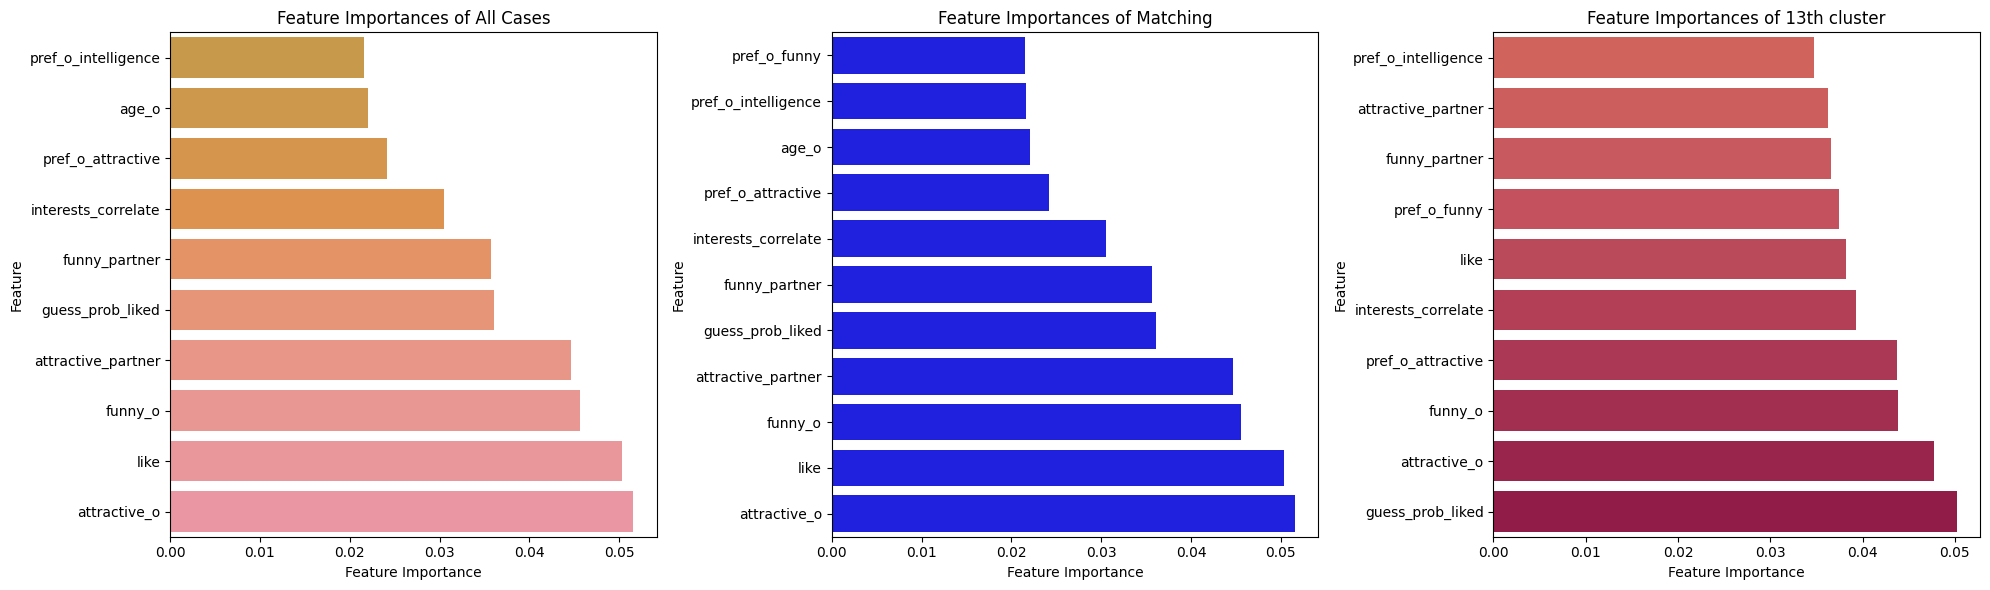

In [68]:
fig, axs = plt.subplots(ncols=3, figsize=(20,6))

sns.barplot(y=X_train.columns[sorted_indices], x=importances[sorted_indices], ax=axs[0])
axs[0].set_ylabel('Feature')
axs[0].set_xlabel('Feature Importance')
axs[0].set_ylim(-0.5, 9.5)
axs[0].set_title('Feature Importances of All Cases')

sns.barplot(y='feature', x='importance', data=importances_match, color='blue', ax=axs[1])
axs[1].set_ylabel('Feature')
axs[1].set_xlabel('Feature Importance')
axs[1].set_ylim(-0.5, 10.5)
axs[1].set_title('Feature Importances of Matching')

sns.barplot(y=cluster_13_train.columns[sorted_indices_13], x=importances_cluster_13[sorted_indices_13], palette='Spectral', ax=axs[2])
axs[2].set_ylabel('Feature')
axs[2].set_xlabel('Feature Importance')
axs[2].set_ylim(-0.5, 9.5)
axs[2].set_title('Feature Importances of 13th cluster')

plt.tight_layout()
plt.show()


<font color='skyblue' size='4'>Apparently, some feature are valued more important in the 13th cluster which have lower importannce in other cases. Since the 'guess_prob_liked' feature means 'How likely do you think it is that your partner likes you?' and the feature 'attractive_o' means 'attractive_o: Rating by partner (about me) at night of event on attractiveness', it is obviouse that in a speed dating event, when they are attracted by each other (maybe mutually or maybe one-sided), this dating is highly likely end up with a 'match'.</font>

<font color='skyblue' size='4'> Unfortunately, some feature that are important in career life, like the 'intellligence', have very low importance. Besides, factors of self-cultivation, such as youga, exercise, sports, art preference, music taste, *etc.* are barely relevant in a speed dating event.</font>

<font color='pink' size='6'>The conclusion, or the ugly truth, is that in a speed dating event, IT IS ALL ABOUT ATTRACTIVENESS! Sense of humour matters!</font>

But what happens for the unmatched instances?

Let's look at the top 10 most important features that leads to unmatch.

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_9495/2759003863.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_unmatch.fit(X_train_unmatch, y_train_unmatch)


Text(0.5, 1.0, 'Feature Importance of Unmatching')

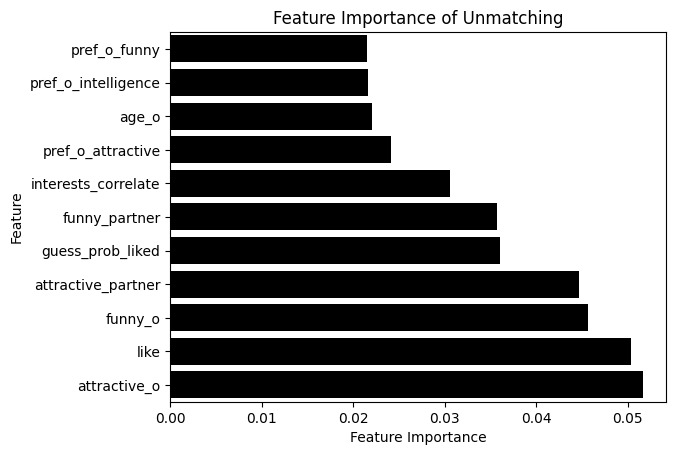

In [69]:
# filter the training data to only include rows where y_train == 1
indices_unmatch = y_train[y_train == 0].index

X_train_unmatch = X_train.loc[indices_unmatch]
y_train_unmatch = y_train.loc[indices_unmatch]

# train a random forest classifier on the filtered data
rfc_unmatch = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_unmatch.fit(X_train_unmatch, y_train_unmatch)

# calculate feature importances for the filtered data
importances_unmatch = rfc_unmatch.feature_importances_

# create a DataFrame of feature importances with column names and sort by importance
importances_unmatch = pd.DataFrame({'feature': X_train.columns, 'importance': importances_unmatch})
importances_unmatch = importances_unmatch.sort_values('importance', ascending=False)

sns.barplot(data=importances_unmatch, x='importance', y='feature', color='black')
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.ylim(-0.5, 10.5)
plt.title('Feature Importance of Unmatching')

<font color='red'>Deja vu! But it is reasonable to have the same top 10 most important features as it is in the matching cases. Becuase people value these features most and when they find they are not satisfied in these features from the partner, obviously they will not match with the partner.</font>

Let's illustrate the match or not with features

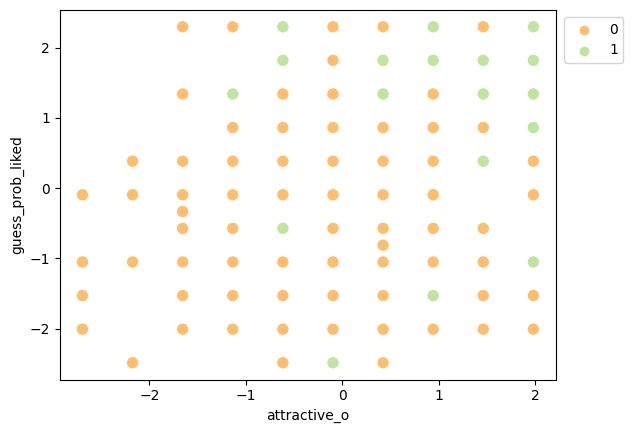

In [120]:
# cluster_13_train = X_train[X_train['birch cluster labels'] == 13]
y_train_13 = y_train[X_train['birch cluster labels'] == 13]

ax = sns.scatterplot(data=cluster_13_train, x='attractive_o', y = 'guess_prob_liked', hue=y_train_13.values.reshape(-1,), palette='Spectral', legend='full', s=80)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

Apparently, the higher the 'attractive_o' and 'guess_prob_liked' the more likely the speed dating ends up with a match. (note that the value of the two features are the encoded values here. I am not going to find the corresponding value of the encoded values in the original data and plot it in the same way.) It is the same for all the cases as seen bellow.

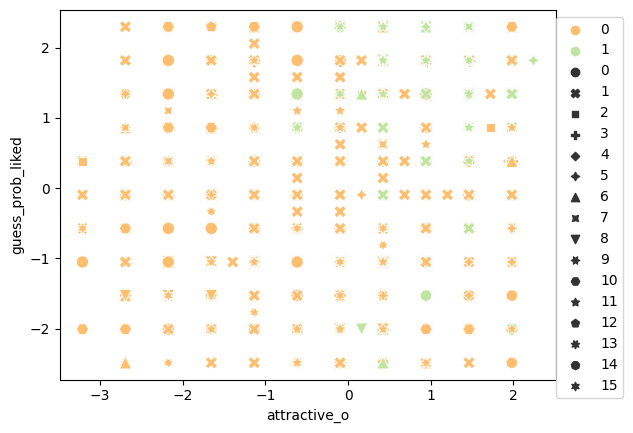

In [134]:
ax = sns.scatterplot(data=Xtrain_with_cluster_labels, 
                    x='attractive_o', 
                    y = 'guess_prob_liked', 
                    hue=ytrain.values.reshape(-1,), 
                    palette='Spectral', 
                    style='birch cluster labels', 
                    legend='full', s=80)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

Let's compare it with the 8th cluster which has the lowest match rate

In [138]:
# Filter the training data to include only the instances that belong to cluster 8
cluster_8_train = X_train[X_train['birch cluster labels'] == 8]
y_train_8 = y_train[X_train['birch cluster labels'] == 8]


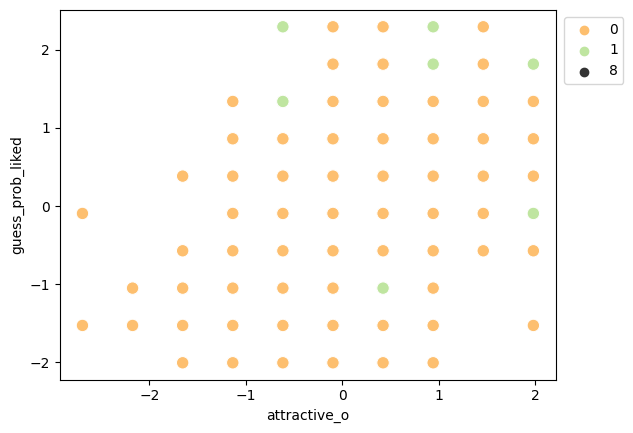

In [139]:
ax = sns.scatterplot(data=cluster_8_train, 
                    x='attractive_o', 
                    y = 'guess_prob_liked', 
                    hue=y_train_8.values.reshape(-1,), 
                    palette='Spectral', 
                    style='birch cluster labels', 
                    legend='full', s=80)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

It is obvious that the matched instances are very less in the upper right part of the graph. However, we still have match that with lower attractive_o (encoded) value (and guess_prob_liked value). It can be further analyzed for these cases to find which feature(s) leads to the match. I will not exhauste this notebook with too much deep analysis but it is interesting for data analysis in production or research.

In [141]:
Xtrain_with_cluster_labels_matching_labels = pd.concat([Xtrain_with_cluster_labels, ytrain], axis = 1)

In [153]:
# define a function that will do scatter plots with selected features, cluster label and match label
def select_plot(cluster_label, match_label, feature_1, feature_2, marker='o', color='blue', ax=None):
    subset_df = Xtrain_with_cluster_labels_matching_labels[(Xtrain_with_cluster_labels_matching_labels['birch cluster labels'] == cluster_label) & (Xtrain_with_cluster_labels_matching_labels['match'] == match_label)]
    return sns.scatterplot(data=subset_df, x=feature_1, y=feature_2, markers=marker, color=color, ax=ax)


In [147]:
Xtrain.columns

Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'race', 'race_o',
       'samerace', 'importance_same_race', 'importance_same_religion', 'field',
       'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'attractive_o', 'sinsere_o',
       'intelligence_o', 'funny_o', 'ambitous_o', 'attractive_important',
       'sincere_important', 'intellicence_important', 'funny_important',
       'ambtition_important', 'attractive', 'sincere', 'intelligence', 'funny',
       'ambition', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner', 'sports',
       'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
       'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music',
       'shopping', 'yoga', 'interests_correlate', 'like', 'guess_prob_liked',
       'met'],
      dtype='object')

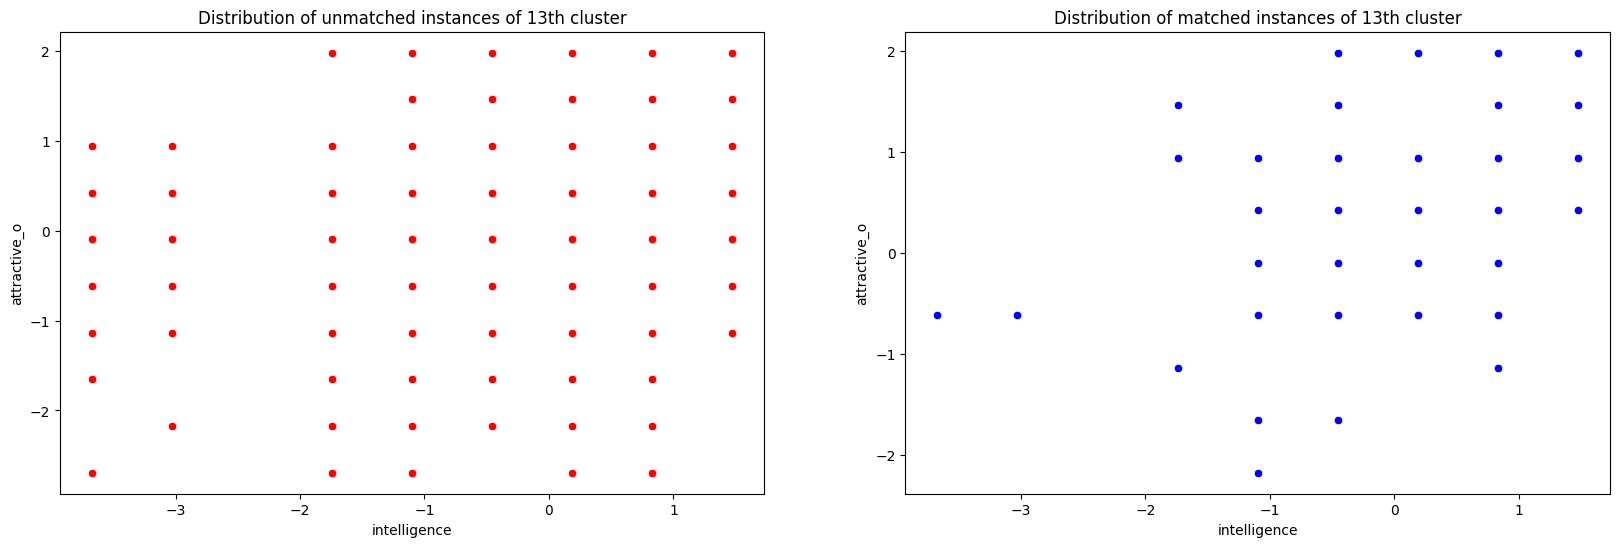

In [154]:
fig, axs = plt.subplots(ncols=2, figsize=(20,6))

select_plot(13, 0, 'intelligence', 'attractive_o', color='red', ax=axs[0])
axs[0].set_title('Distribution of unmatched instances of 13th cluster')
select_plot(13, 1, 'intelligence', 'attractive_o', ax=axs[1])
axs[1].set_title('Distribution of matched instances of 13th cluster')

plt.show()

We can tell that a person of high 'attractive_o' (encoded) value and he/she is likely has high 'intelligence' (encoded) values in the match case. But in the unmatched case, two features are sparsely distributed. This conclusion can be verified by plotting more figures for different clusters, see below.

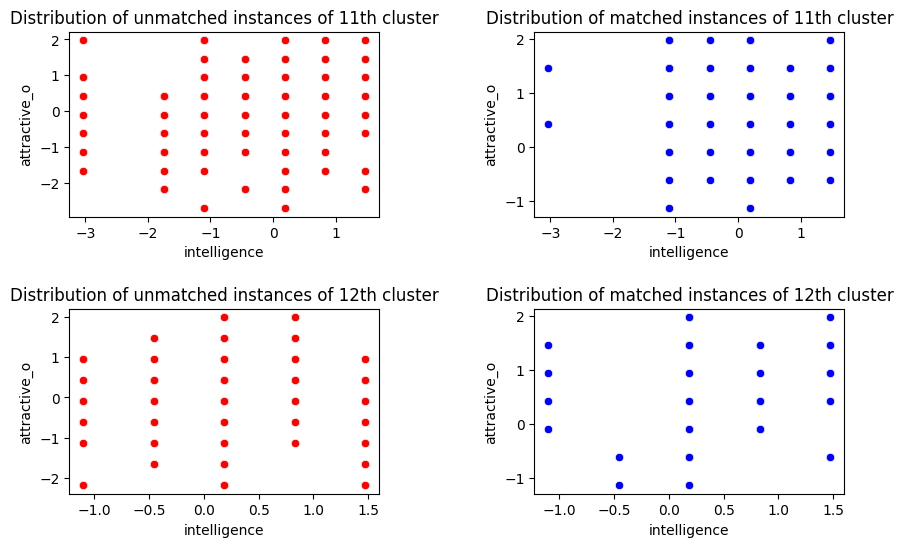

In [164]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6))

select_plot(11, 0, 'intelligence', 'attractive_o', color='red', ax=axs[0,0])
axs[0,0].set_title('Distribution of unmatched instances of 11th cluster')
select_plot(11, 1, 'intelligence', 'attractive_o', ax=axs[0,1])
axs[0,1].set_title('Distribution of matched instances of 11th cluster')

select_plot(12, 0, 'intelligence', 'attractive_o', color='red', ax=axs[1,0])
axs[1,0].set_title('Distribution of unmatched instances of 12th cluster')
select_plot(12, 1, 'intelligence', 'attractive_o', ax=axs[1,1])
axs[1,1].set_title('Distribution of matched instances of 12th cluster')

fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

With more time and more specific task, I can find more informations from this clustering results. Such as what makes the clusters different in their size, how features are distibuted in a specific cluster in terms of mathed or not. But I don't have enough time to work on it.

## Now I show you the beautiful side of the dating world 

(not real analysis for the exam, just adding flavor to the exhuating data analysis work)

<Axes: >

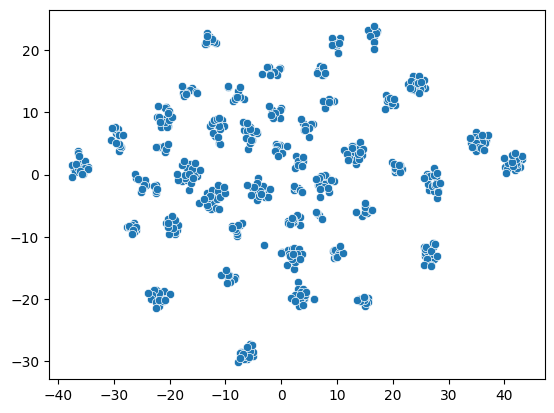

In [73]:
# Let's get all the data of 13th cluster
cluster13 = Xtrain_with_cluster_labels[Xtrain_with_cluster_labels['birch cluster labels']==13].sort_values(by='attractive_o', ascending=False)

# Redo the feature projection for 13th cluster
reducer = TSNE(n_components=2, random_state=42)
embedding = reducer.fit_transform(cluster13)

# let's make a plot
sns.scatterplot(x=embedding[:,0], y=embedding[:,1])

**<font color='pink' size='20'> Shape of HEART </font>**  <font size='20'>💖</font>

## Experiment to optimize the cluster number and threshold with silhouette score and calinski-baraharsz score

By back-and-forth optimization between the cluster number and threshold, we can have an optimial solution of the cluster number and threshold, but I don't like the results for the production. Try it, you'll see.

### Silhouette Score

/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (10) by BIRCH is less than (11). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (10) by BIRCH is less than (12). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (10) by BIRCH is less than (13). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (10) by BIRCH is less than (14). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclus

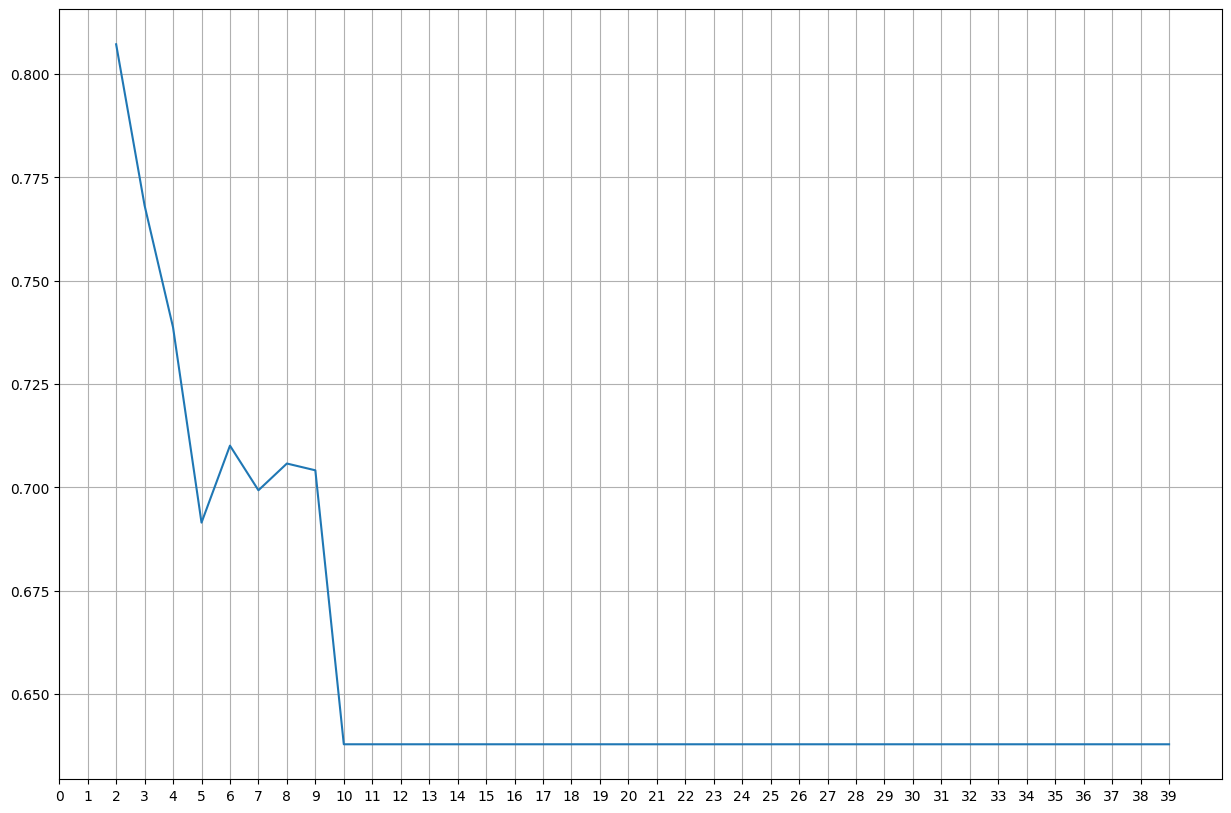

In [92]:
scores = []
cluster_n = list(range(2, 40))
for n in cluster_n:
    birch = build_model(n_clusters=n, threshold=18.5, branching_factor=50)[-2]['model'].fit(Xtrain_encoded)
    labels = birch.labels_
    score = silhouette_score(Xtrain_encoded, labels)
    scores.append(score)

fig = plt.figure(figsize=(15,10))
plt.plot(cluster_n, scores)
plt.xticks(np.arange(0,40))
plt.grid('on')
plt.show()

/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (9) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters

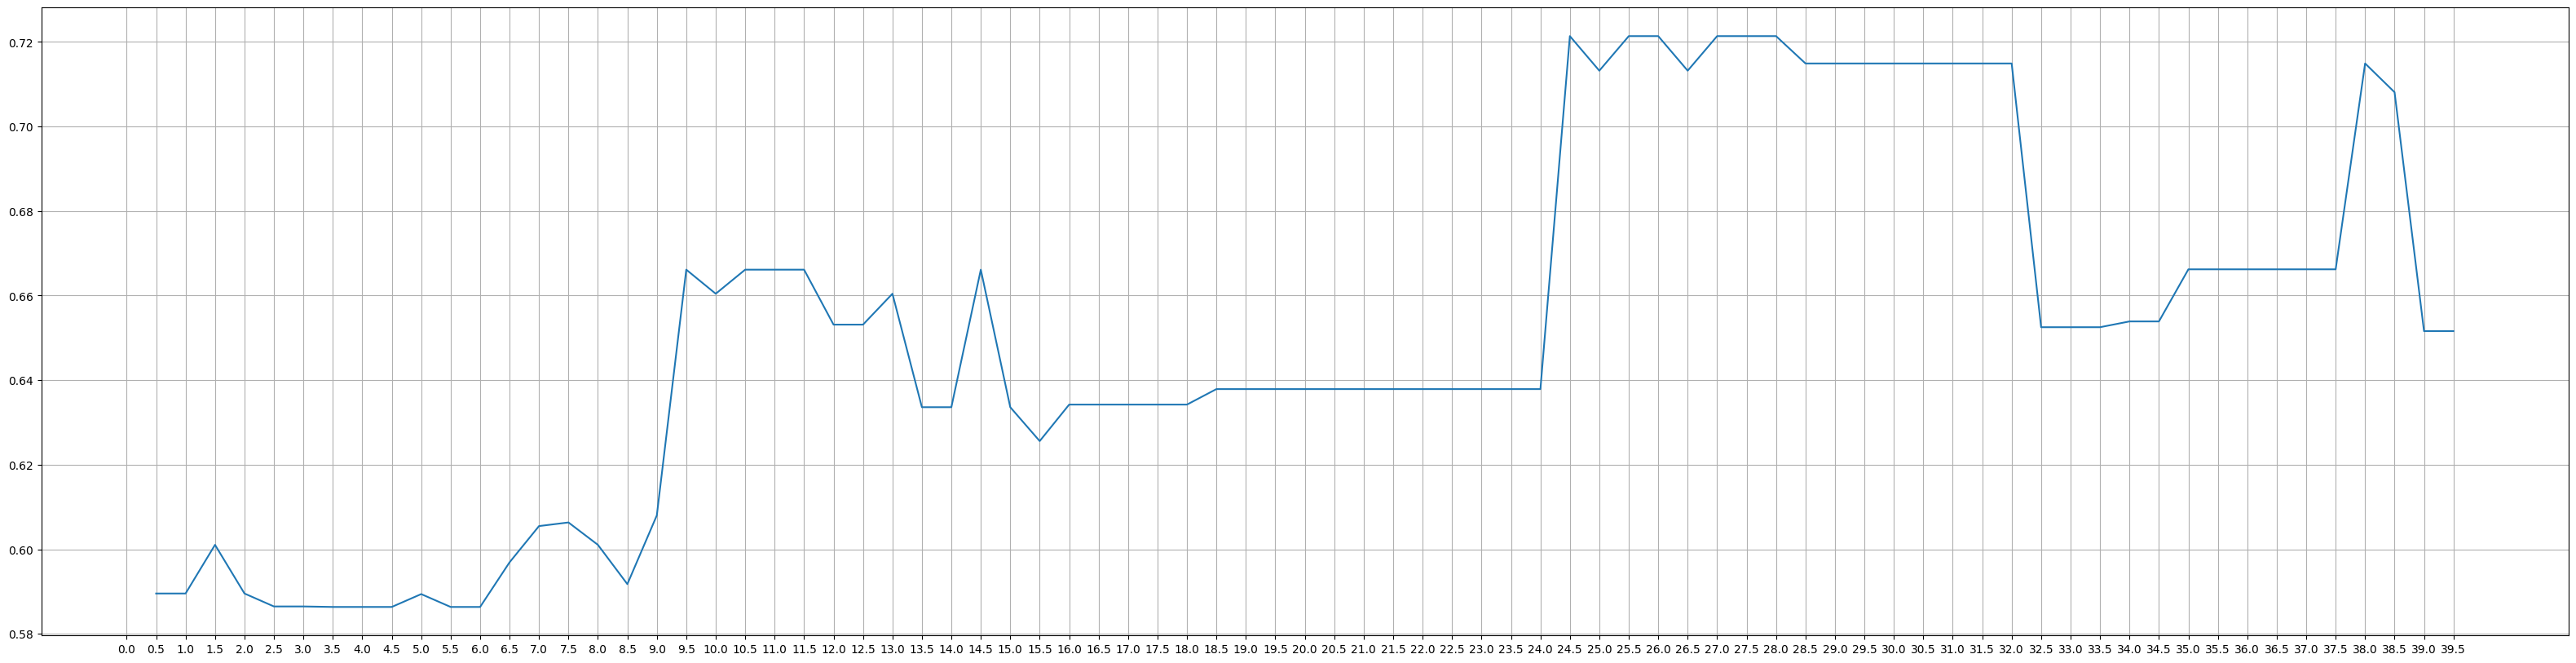

In [93]:
thresholds = list(range(1, 80, 1))
thresholds = [x / 2 for x in thresholds]
scores = []
for threshold in thresholds:
    birch = build_model(n_clusters = 10, threshold = threshold, branching_factor=50)[-2]['model'].fit(Xtrain_encoded)
    labels = birch.labels_
    score = silhouette_score(Xtrain_encoded, labels)
    scores.append(score)

fig = plt.figure(figsize=(40,10))
plt.plot(thresholds, scores)
plt.xticks(np.arange(0, 40, 0.5))
plt.grid('on')
plt.show()

### Calinski-Baraharsz Score

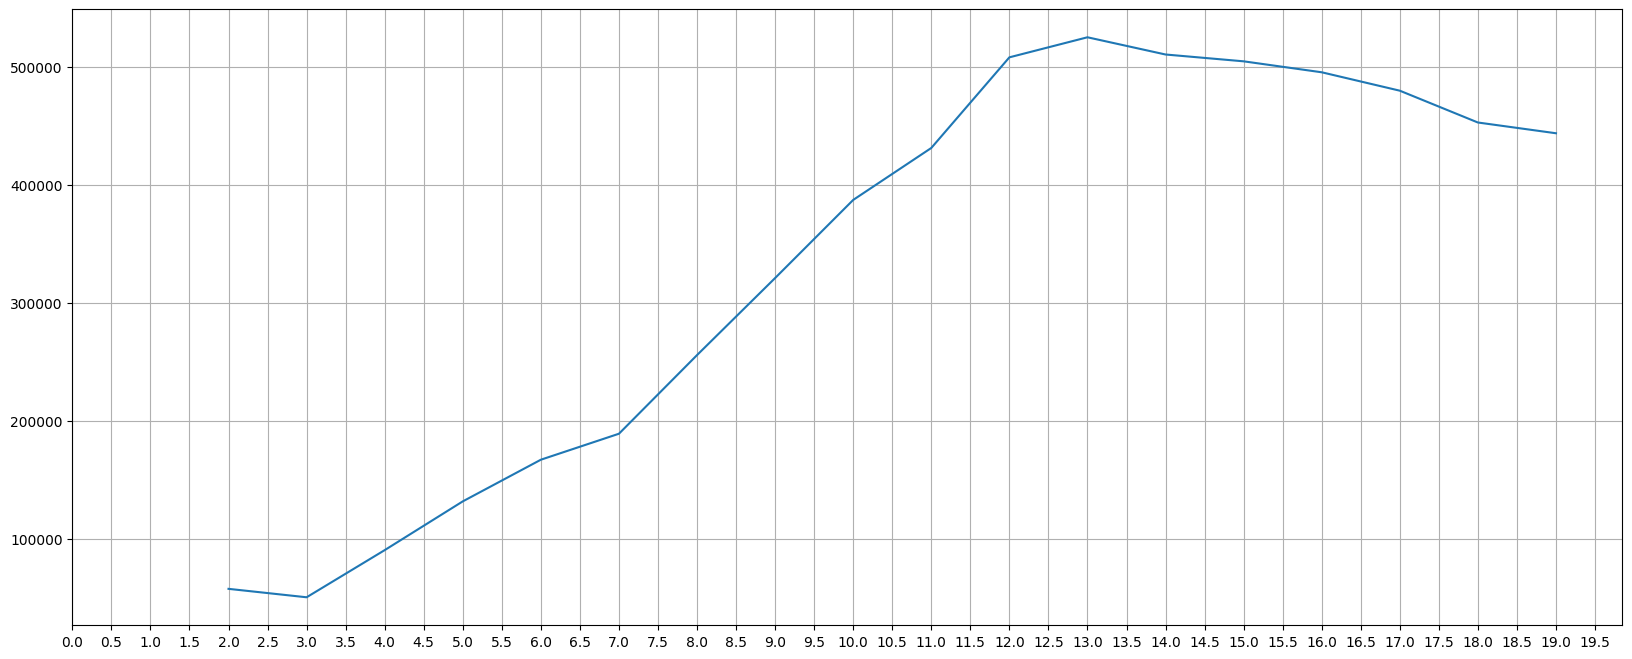

In [94]:
from sklearn.metrics import calinski_harabasz_score
scores = []
cluster_n = list(range(2, 20))
for n in cluster_n:
    birch = build_model(n_clusters=n, threshold=5, branching_factor=50)[-2]['model'].fit(Xtrain_encoded)
    labels = birch.labels_
    score = calinski_harabasz_score(Xtrain_encoded, labels)
    scores.append(score)

fig = plt.figure(figsize=(20, 8))
plt.plot(cluster_n, scores)
plt.xticks(np.arange(0,20, 0.5))
plt.grid('on')
plt.show()

/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (12) by BIRCH is less than (13). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (12) by BIRCH is less than (13). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (12) by BIRCH is less than (13). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (12) by BIRCH is less than (13). Decrease the threshold.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclus

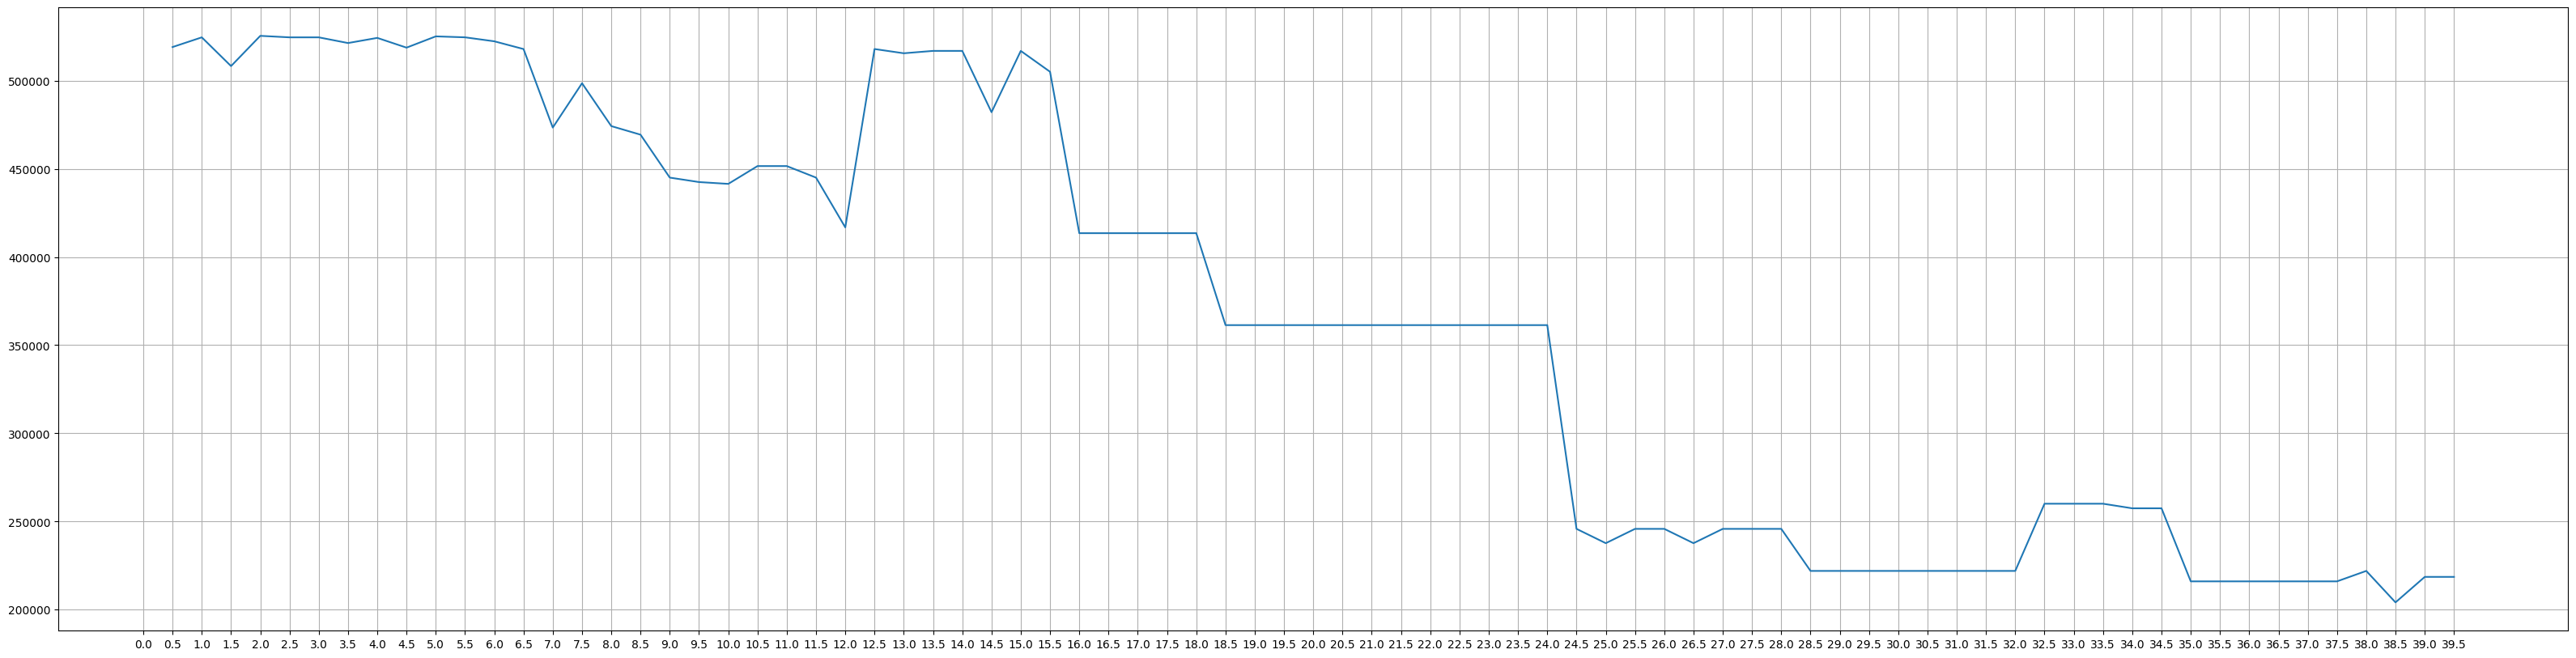

In [95]:
thresholds = list(range(1, 80, 1))
thresholds = [x / 2 for x in thresholds]
scores = []
for threshold in thresholds:
    birch = build_model(n_clusters = 13, threshold = threshold, branching_factor=50)[-2]['model'].fit(Xtrain_encoded)
    labels = birch.labels_
    score = calinski_harabasz_score(Xtrain_encoded, labels)
    scores.append(score)

fig = plt.figure(figsize=(40,10))
plt.plot(thresholds, scores)
plt.xticks(np.arange(0, 40, 0.5))
plt.grid('on')
plt.show()

# The rest is the experiments with other models that I have done with the latest results displayed

## DBSCAN

Available metric values:
'sokalmichener', 'rogerstanimoto', 'cosine', 'braycurtis', 'sokalsneath', 'dice', 'nan_euclidean', 'precomputed', 'l2', 'matching', 'canberra', 'l1', 'yule', 'cityblock', 'kulsinski', 'correlation', 'jaccard', 'sqeuclidean', 'euclidean', 'haversine', 'seuclidean', 'hamming', 'wminkowski', 'russellrao', 'manhattan', 'mahalanobis', 'minkowski', 'chebyshev'

In [74]:
models = build_model(eps=6, min_samples=10, metric='minkowski', algorithm='kd_tree', leaf_size=30, p=3, n_jobs=-1)
dbscan_model = models[-1]
dbscan_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 DBSCAN(eps=6, metric='minkowski', min_samples=10, n_jobs=-1,
                        p=3))])

In [75]:
from sklearn.metrics import silhouette_score

db_labels_train = dbscan_model.fit_predict(Xtrain)
db_silhouette_score_train = silhouette_score(Xtrain_encoded, db_labels_train.reshape(-1,))
print(db_silhouette_score_train)

0.20498498028649878


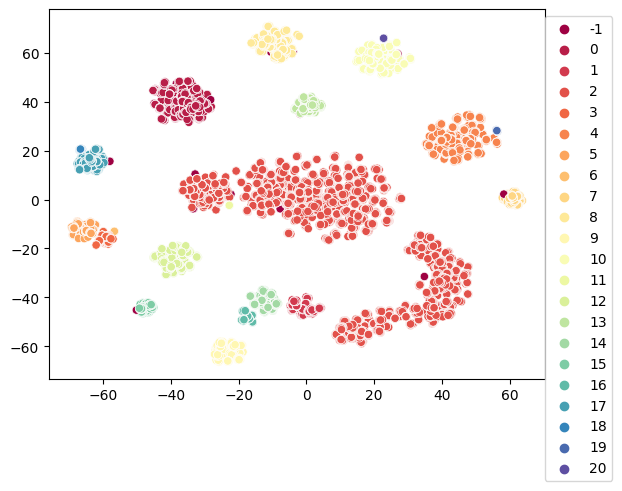

In [76]:
ax = sns.scatterplot(x=tsne_embeding_train[:,1], y=tsne_embeding_train[:,0], hue=db_labels_train, palette='Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

## KMEANS

In [77]:
models = build_model(n_clusters=16, init='random', n_init=4, max_iter=300, tol=1e-8, verbose=8, random_state=42, algorithm_k='lloyd')
km_model = models[1]
km_model.fit(Xtrain)

Initialization complete
Iteration 0, inertia 4029529.7657196643.
Iteration 1, inertia 2379061.206940025.
Iteration 2, inertia 2014862.5525976429.
Iteration 3, inertia 2007903.031882093.
Iteration 4, inertia 2004584.1729828045.
Iteration 5, inertia 2003658.3004944946.
Iteration 6, inertia 2003389.8387642931.
Iteration 7, inertia 2003197.2563898363.
Iteration 8, inertia 2003044.4164570053.
Iteration 9, inertia 2002886.7647472674.
Iteration 10, inertia 2002796.8865362264.
Iteration 11, inertia 2002725.3610889614.
Iteration 12, inertia 2002642.580584372.
Iteration 13, inertia 2002527.2952017607.
Iteration 14, inertia 2002504.4323210907.
Iteration 15, inertia 2002502.9948265348.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 16129333.647846831.
Iteration 1, inertia 5091144.032951236.
Iteration 2, inertia 2186271.5224847505.
Iteration 3, inertia 1594903.6291543858.
Iteration 4, inertia 1559398.058805243.
Iteration 5, inertia 1537198.2594909372.
It

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 KMeans(init='random', n_clusters=16, n_init=4, random_state=42,
                        tol=1e-08, verbose=8))])

In [78]:
km_labels_train = km_model.fit_predict(Xtrain)

km_silhouette_score_train = silhouette_score(Xtrain_encoded, km_labels_train)
print(km_silhouette_score_train)

Initialization complete
Iteration 0, inertia 4029529.7657196643.
Iteration 1, inertia 2379061.2069400256.
Iteration 2, inertia 2014862.552597643.
Iteration 3, inertia 2007903.0318820933.
Iteration 4, inertia 2004584.1729828045.
Iteration 5, inertia 2003658.3004944946.
Iteration 6, inertia 2003389.8387642931.
Iteration 7, inertia 2003197.2563898363.
Iteration 8, inertia 2003044.4164570048.
Iteration 9, inertia 2002886.7647472671.
Iteration 10, inertia 2002796.8865362264.
Iteration 11, inertia 2002725.3610889614.
Iteration 12, inertia 2002642.5805843722.
Iteration 13, inertia 2002527.295201761.
Iteration 14, inertia 2002504.4323210907.
Iteration 15, inertia 2002502.9948265352.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 16129333.647846831.
Iteration 1, inertia 5091144.032951236.
Iteration 2, inertia 2186271.5224847505.
Iteration 3, inertia 1594903.6291543858.
Iteration 4, inertia 1559398.0588052433.
Iteration 5, inertia 1537198.259490937.
I

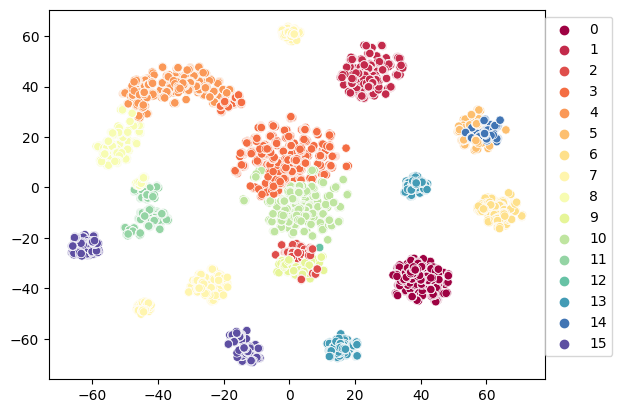

In [79]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=km_labels_train, palette= 'Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

## OPTICS
<font color='red'> Warning: it is very slow</font>


- Valid values for metric are:

    - from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]

    - from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

    Sparse matrices are only supported by scikit-learn metrics. See the documentation for scipy.spatial.distance for details on these metrics.

- Algorithm used to compute the nearest neighbors:

    - ‘ball_tree’ will use BallTree.

    - ‘kd_tree’ will use KDTree.

    - ‘brute’ will use a brute-force search.

    - ‘auto’ (default) will attempt to decide the most appropriate algorithm based on the values passed to fit method.

In [ ]:
models = build_model(min_samples=50, metric='euclidean', p=2, cluster_method='xi', min_cluster_size=2, algorithm='auto', leaf_size=30)
op_model = models[2]
op_model.fit(Xtrain)

In [ ]:
op_labels_train = op_model.fit_predict(Xtrain)
op_labels_test = op_model.fit_predict(Xtest)
# op_silhouette_score_train = silhouette_score(Xtrain_encoded, op_labels_train)
# op_silhouette_score_test = silhouette_score(Xtest_encoded, op_labels_test)
# print(op_silhouette_score_train)
# print(op_silhouette_score_test)

In [ ]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=op_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

## AgglomerativeClustering

In [80]:
from sklearn.cluster import AgglomerativeClustering

agg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', AgglomerativeClustering(n_clusters=12, linkage='average', metric='seuclidean'))
])

In [81]:
agg.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 AgglomerativeClustering(linkage='average', metric='seuclidean',
                                         n_clusters=12))])

In [83]:
agg_labels_train = agg.fit_predict(Xtrain)
# agg_labels_test = agg.fit_predict(Xtest)
# agg_silhou_train = silhouette_score(Xtrain_encoded, agg_labels_train.reshape(-1, ))
# agg_silhou_test = silhouette_score(Xtest_encoded, agg_labels_test.reshape(-1, ))
# print('Silhouette score of agglomerative cluster model on train dataset: ', agg_silhou_train)
# print('Silhouette score of agglomerative cluster model on test dataset: ', agg_silhou_test)

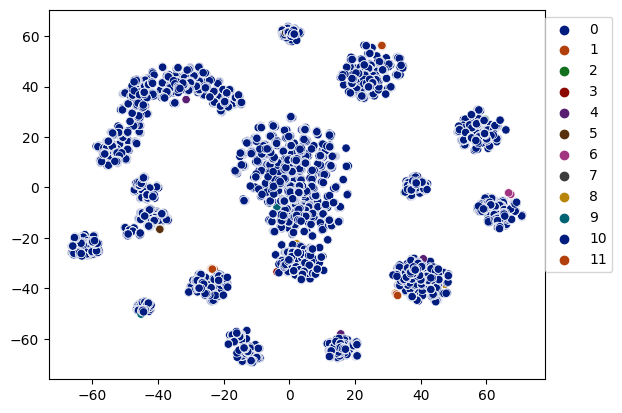

In [84]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=agg_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

## BisectingKMeans

In [90]:
from sklearn.cluster import BisectingKMeans

bikm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BisectingKMeans(n_clusters=16, init='k-means++'))
])
bikm.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model', BisectingKMeans(init='k-means++', n_clusters=16))])

In [89]:
bikm_labels_train = bikm.fit_predict(Xtrain)
# bikm_labels_test = bikm.fit_predict(Xtest)

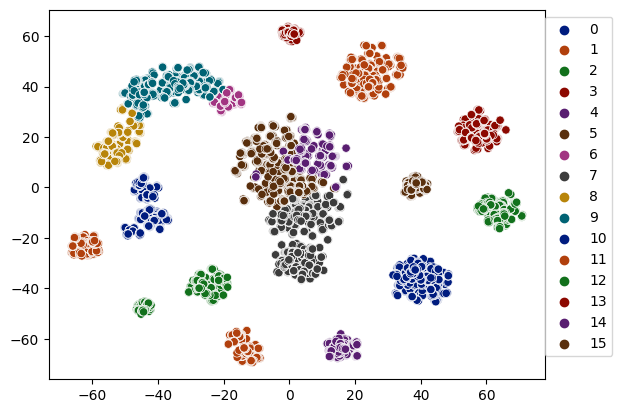

In [91]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=bikm_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()